# Advanced McStas features:  SPLIT
McStas uses the Monte Carlo ray-tracing technique, which allows some tricks in how the physics is sampled as long as the resulting probability distributions matches the physics. This is possible as each ray has a weight, corresponding to how much intensity this ray represent. The SPLIT keyword can be used to split a ray into many equal parts, which can be useful if the remaining instrument has many different simulated and random outcomes. In this tutorial we will use the SPLIT keyword on a powder sample, as there are many powder Bragg peaks each ray could select, and splitting the ray samples this more efficiently.

### Setting up an example instrument
First we set up an example instrument, this is taken from the basic tutorial and correspond of source, guide, monochromator, sample and banana detector.

In [1]:
from mcstasscript.interface import instr, functions, plotter

In [2]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder",
                                output_path="data_folder/mcstas_SPLIT")

In [3]:
instrument.add_component("Origin", "Progress_bar")

src = instrument.add_component("source", "Source_div")
src.xwidth = 0.1
src.yheight = 0.05
src.focus_aw = 1.2
src.focus_ah = 2.3

wavelength = instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
src.lambda0 = wavelength
src.dlambda = "0.03*wavelength"

guide = instrument.add_component("guide", "Guide_gravity", AT=[0,0,2], RELATIVE=src)
guide.w1 = 0.05
guide.w2 = 0.05
guide.h1 = 0.05
guide.h2 = 0.05
guide.l = 8.0
guide.m = 3.5
guide.G = -9.82

mono_Q = instrument.add_declare_var("double", "mono_Q", value=1.714) # Q for Ge 311
instrument.add_declare_var("double", "wavevector")
instrument.append_initialize("wavevector = 2.0*PI/wavelength;")

mono_rotation = instrument.add_declare_var("double", "mono_rotation")
instrument.append_initialize("mono_rotation = asin(mono_Q/(2.0*wavevector))*RAD2DEG;")
instrument.append_initialize('printf("monochromator rotation = %g deg\\n", mono_rotation);')

mono = instrument.add_component("mono", "Monochromator_flat")
mono.zwidth = 0.05
mono.yheight = 0.08
mono.Q = mono_Q
mono.set_AT([0, 0, 8.5], RELATIVE=guide)
mono.set_ROTATED([0, mono_rotation, 0], RELATIVE=guide)

beam_direction = instrument.add_component("beam_dir", "Arm", AT_RELATIVE=mono)
beam_direction.set_ROTATED([0, "mono_rotation", 0], RELATIVE="mono")

sample = instrument.add_component("sample", "PowderN", AT=[0,0,1.1], RELATIVE=beam_direction)
sample.radius = 0.015
sample.yheight = 0.05
sample.reflections = '"Na2Ca3Al2F14.laz"'

banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 2.0
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[5 175] bins=150, banana"'

### Running the simulation
Here we run the simulation with very few neutrons to show problematic sampling.

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_116"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_116

      monochromator rotation = 22.4519 deg
[python_tutorial] Initialize
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standard NAC cal ...'
PowderN: sample: Reading 841 rows from Na2Ca3Al2F14.laz
PowderN: sample: Read 841 reflections 

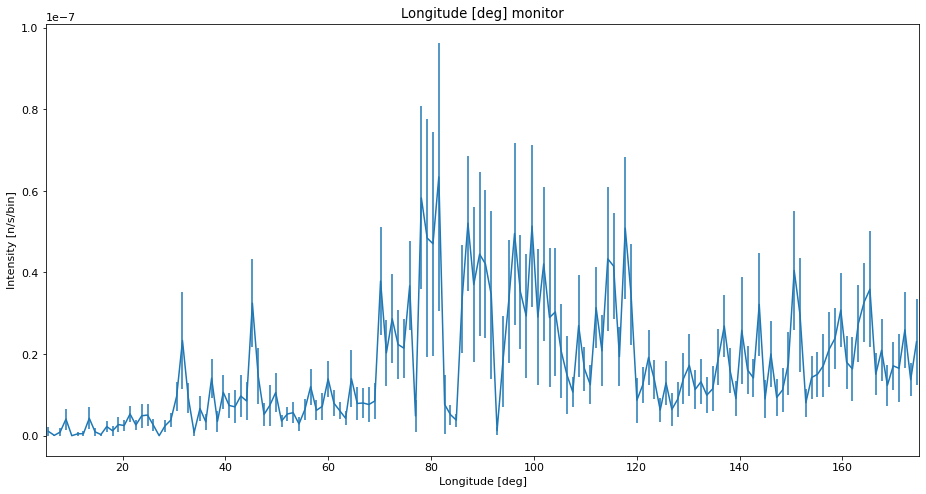

In [4]:
instrument.settings(ncount=1E6)

instrument.set_parameters(wavelength=2.8)
                          
instrument.backengine()
data_low = instrument.data

In [ ]:
plotter.make_sub_plot(data_low)

### Adding the SPLIT keyword
Here we add the SPLIT keyword to the sample, we choose to split each ray into 30.

In [5]:
sample.set_SPLIT(30)

In [6]:
# No need to set settings or parameters as these have not changed
instrument.backengine()
data_reasonable = instrument.data

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_117"
INFO: Regenerating c-file: python_tutorial.c
Info:    Defining SPLIT from sample=PowderN() to END in instrument python_tutorial
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_117

      monochromator rotation = 22.4519 deg
[python_tutorial] Initialize
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standard NAC cal ...'
PowderN: sa

Plotting data with name banana


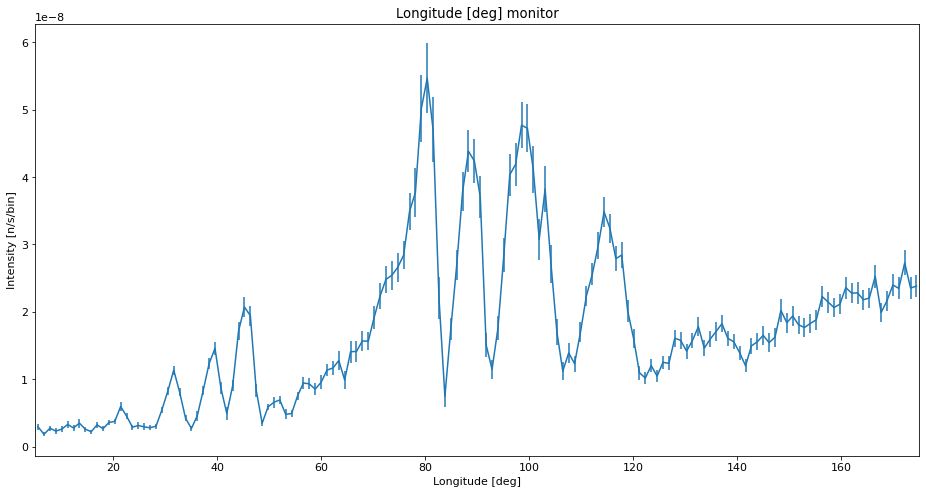

In [7]:
plotter.make_sub_plot(data_reasonable)

### Caution on split value
It is however possible to mismanage splitting, mainly by simulating a too few rays and splitting too much. Here we do this on purpose to see how such data would look. 

In [8]:
sample.set_SPLIT(10000)

instrument.settings(ncount=1E3) # Change settings to lower ncount, but keep parameters
                          
instrument.backengine()
data_unreasonable = instrument.data

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_118"
INFO: Regenerating c-file: python_tutorial.c
Info:    Defining SPLIT from sample=PowderN() to END in instrument python_tutorial
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
         is probably too low. Increase Ncount.
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_118

      monochromator rotation = 22.4519 deg
[python_tutorial] Initialize
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Fe

Plotting data with name banana


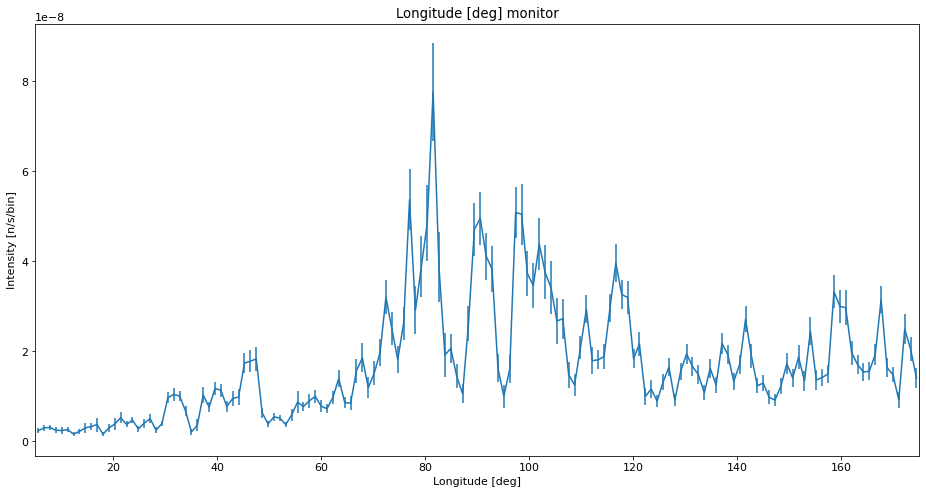

In [9]:
plotter.make_sub_plot(data_unreasonable)

### Comparison with high statistics run
We here compare the different runs to a reference. The reference run is set up to have 50 times more rays than the earlier runs with 5E7 instead of 1E6 rays.

In [10]:
sample.set_SPLIT(1)
instrument.settings(ncount=2E7)
                          
instrument.backengine()
data_ref = instrument.data

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_119"
INFO: Regenerating c-file: python_tutorial.c
Info:    Defining SPLIT from sample=PowderN() to END in instrument python_tutorial
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/mcstas_SPLIT_119

      monochromator rotation = 22.4519 deg
[python_tutorial] Initialize
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standard NAC cal ...'
PowderN: sa

Plotting data with name banana


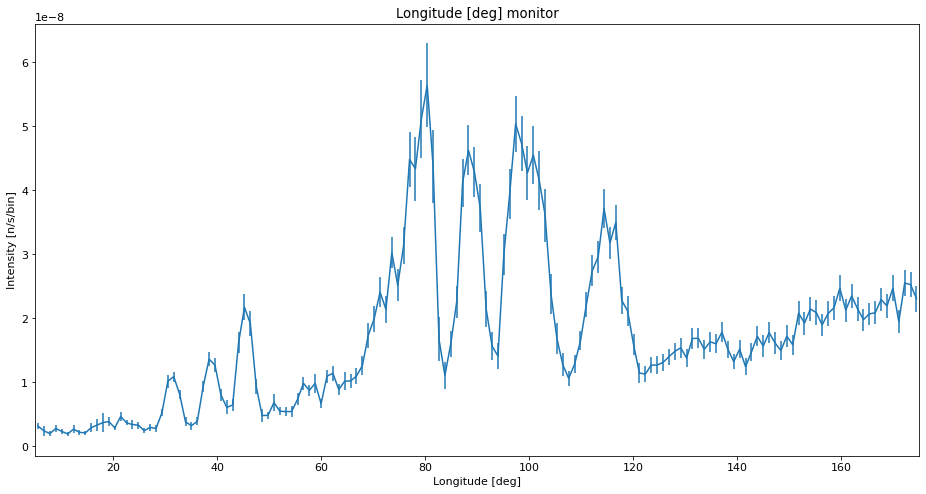

In [11]:
plotter.make_sub_plot(data_ref)

### Plotting data on same plot
Here we only have one monitor in each data list, but we still use the *name_search* function to retrieve the correct data object from each. This avoids the code breaking in case additional monitors are added.

Once we have the objects, we use the *xaxis*, *Intensity* and *Error* attributes to plot the data with matplotlib.

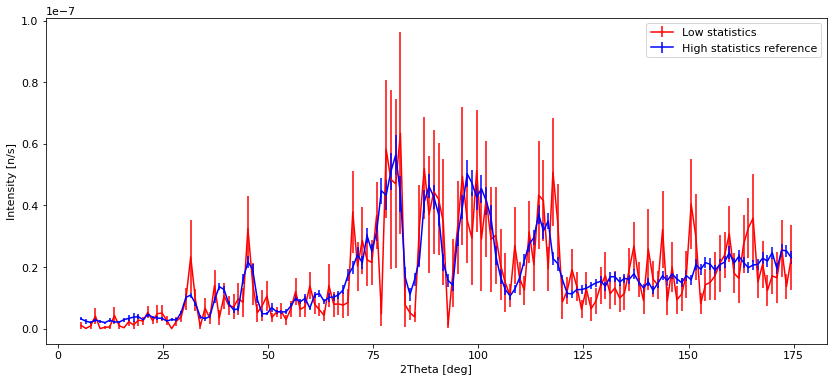

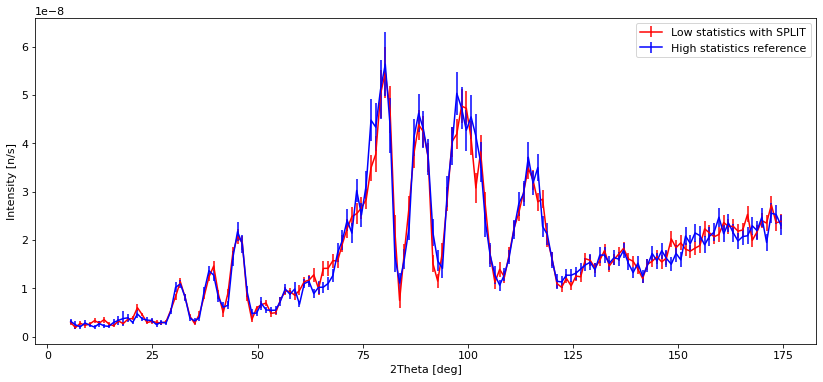

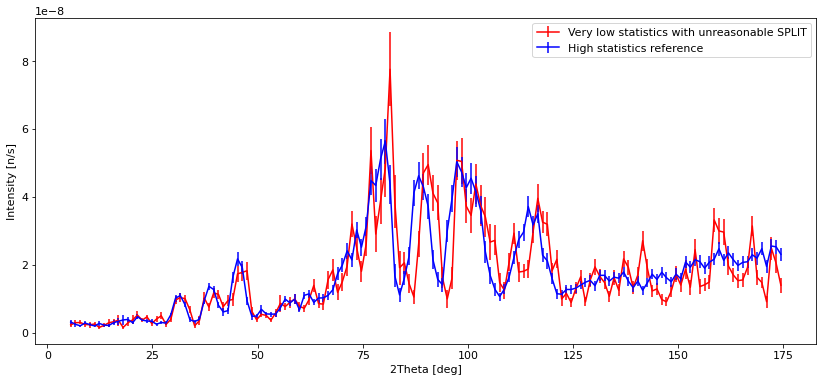

In [12]:
import matplotlib.pyplot as plt
banana_low = functions.name_search("banana", data_low)
banana_reasonable = functions.name_search("banana", data_reasonable)
banana_unreasonable = functions.name_search("banana", data_unreasonable)
banana_ref = functions.name_search("banana", data_ref)

plt.figure(figsize=(14,6))
plt.errorbar(banana_low.xaxis, banana_low.Intensity, yerr=banana_low.Error, fmt="r")
plt.errorbar(banana_ref.xaxis, banana_ref.Intensity, yerr=banana_ref.Error, fmt="b")
plt.xlabel("2Theta [deg]")
plt.ylabel("Intensity [n/s]")
plt.legend(["Low statistics", "High statistics reference"])

plt.figure(figsize=(14,6))
plt.errorbar(banana_reasonable.xaxis, banana_reasonable.Intensity,
             yerr=banana_reasonable.Error, fmt="r")
plt.errorbar(banana_ref.xaxis, banana_ref.Intensity, yerr=banana_ref.Error, fmt="b")
plt.xlabel("2Theta [deg]")
plt.ylabel("Intensity [n/s]")
plt.legend(["Low statistics with SPLIT", "High statistics reference"])

plt.figure(figsize=(14,6))
plt.errorbar(banana_unreasonable.xaxis, banana_unreasonable.Intensity,
             yerr=banana_unreasonable.Error, fmt="r")
plt.errorbar(banana_ref.xaxis, banana_ref.Intensity, yerr=banana_ref.Error, fmt="b")
plt.xlabel("2Theta [deg]")
plt.ylabel("Intensity [n/s]")
l = plt.legend(["Very low statistics with unreasonable SPLIT", "High statistics reference"])

### Interpretation of the data
We see that with low statistics, the data quality is so bad that noise can be mistaken for peaks. Using SPLIT improves the situation a lot, and the data is very similar to the high statistics reference which takes longer to compute. The situation with a low number of simulated rays and very high SPLIT have some erratic behavior, showing some very different peak intensities than the reference, and some peaks that shouldn't be there at all.